In [1]:
#Getting data
import os
from urllib.request import urlretrieve

Carina_url = "http://vizier.cfa.harvard.edu/viz-bin/nph-Cat/csv?J%2FAJ%2F137%2F3100/table2.dat"
Fornax_url = "http://vizier.cfa.harvard.edu/viz-bin/nph-Cat/csv?J%2FAJ%2F137%2F3100/table3.dat"
Sculptor_url = "http://vizier.cfa.harvard.edu/viz-bin/nph-Cat/csv?J%2FAJ%2F137%2F3100/table4.dat"
Sextans_url = "http://vizier.cfa.harvard.edu/viz-bin/nph-Cat/csv?J%2FAJ%2F137%2F3100/table5.dat"

dSph = {Carina_url:"Carina.txt",Fornax_url:"Fornax.txt",Sculptor_url:"Sculptor.txt",Sextans_url:"Sextans.txt"}
def get_data(filename, url):
    if not os.path.exists(filename):
        urlretrieve(url, filename)

for i in dSph:
    get_data(dSph[i],i)

In [2]:
#Reading data
import pandas as pd
dataall = pd.read_table("Carina.txt", sep = '\t', header = 0,skiprows = range(1,3))
dataall.head()


,Target,Field,HJD,RAh,RAm,RAs,DE-,DEd,DEm,DEs,...,e_HV,SigFe,e_SigFe,SigMg,e_SigMg,Mmb,<HV>,e_<HV>,<SigMg>,e_<SigMg>
0,Car-0001,18B,3087.533,6,42,17.94,-,50,53,58.4,...,2.0,0.42,0.05,0.48,0.10,1.000,219.0,2.0,0.49,0.10
1,Car-0001,1R,4554.518,6,42,17.94,-,50,53,58.4,...,10.3,0.21,0.28,0.53,0.30,,,,,NaN
2,Car-0002,18B,3087.533,6,42,18.60,-,50,54,27.6,...,0.6,0.38,0.02,0.45,0.05,1.000,235.5,0.6,0.44,0.04
3,Car-0002,1R,3088.572,6,42,18.60,-,50,54,27.6,...,5.8,0.43,0.02,0.46,0.09,,,,,NaN
4,Car-0002,25R,3411.554,6,42,18.60,-,50,54,27.6,...,6.2,0.37,0.07,0.24,0.15,,,,,NaN


In [3]:
#Removing Mmb<0.5, foreground stars
for i in range(len(dataall['Mmb'])):
    if dataall['Mmb'][i] == '     ':
        dataall['Mmb'][i] = dataall['Mmb'][i-1]
        
Nbad = [] 
for i in range(len(dataall['Mmb'])):
    if float(dataall['Mmb'][i]) < 0.5:
        Nbad.append(i+1)

dataall.to_csv('CarinaI.txt',sep = '\t')

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [4]:
data = pd.read_csv("CarinaI.txt", sep = '\t', header = 0, skiprows = Nbad)
if 'Unnamed: 0' in data.columns:
    del data['Unnamed: 0']
data.head()

for i in range(len(data['Mmb'])):
    if float(data['Mmb'][i]) < 0.5:
        print("error: foreground star" + " row  " + str(i))

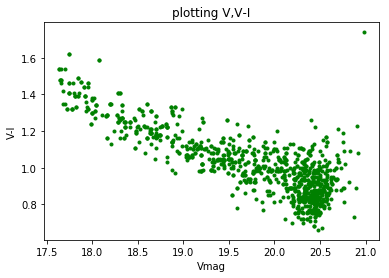

In [5]:
#plotting V,V-I
import pylab
%matplotlib inline

x = data['Vmag']
y = data['V-I']
pylab.xlabel('Vmag')
pylab.ylabel('V-I')
pylab.title('plotting V,V-I')
pylab.plot(x, y,'.g')

In [6]:
#Calculating Fe/H, not reduced
Fehzw84 = []
Fehcg97 = []
for i in range(len(data['SigMg'])):
    try:
        z = float(data['SigMg'][i])
        #Fehzw84.append(float(round(1.93*z - 2.34,2)))
        #Fehcg97.append(float(round(1.76 *z - 2.11,2)))
        Fehzw84.append(float(1.93*z - 2.34))
        Fehcg97.append(float(1.76 *z - 2.11))
    except:
        Fehzw84.append(None)
        Fehcg97.append(None)
        

In [15]:
#Calculating <V>
Vmed = []
import math
w = data['e_HV'][0]**(-2) 
wV = data['e_HV'][0]**(-2) * data['HV'][0]
target = []
dist2 = []
for i in range(len(data['HV'])-1): 
    if data['Target'][i] == data['Target'][i+1]:
        w += data['e_HV'][i+1]**(-2) 
        wV += data['e_HV'][i+1]**(-2) * data['HV'][i+1]
    else:
        target.append(data['Target'][i])
        distt2 = math.cos( ((data['DEd'][i]-50)*60+ (data['DEm'][i]-57) + (data['DEs'][i]-58)/60) * math.pi/180/60)* math.cos(((data['RAh'][i]-6)*60 + (data['RAm'][i]-41) + (data['RAs'][i]-36.7)/60)* math.pi/180/60)
        dist2.append(math.acos(distt2)*60*180/math.pi)
        
        Vmed.append(wV/w)
        w = data['e_HV'][i+1]**(-2) 
        wV = data['e_HV'][i+1]**(-2) * data['HV'][i+1]

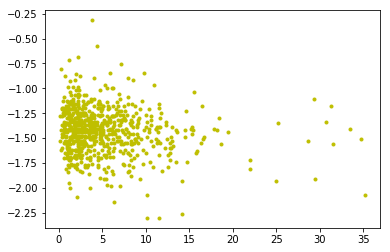

In [8]:
#plotting Fe/H ...dist
#dodyvytys

dist = [] #arcmin
for i in range(len(data['DEd'])):
    distt = math.cos( ((data['DEd'][i]-50)*60+ (data['DEm'][i]-57) + (data['DEs'][i]-58)/60) * math.pi/180/60)* math.cos(((data['RAh'][i]-6)*60 + (data['RAm'][i]-41) + (data['RAs'][i]-36.7)/60)* math.pi/180/60)
        #Carina center coordinates ICRS coord. (ep=J2000) 06 41 36.7 -50 57 58
    dist.append(math.acos(distt)*60*180/math.pi)

pylab.plot(dist, Fehcg97, '.y' )

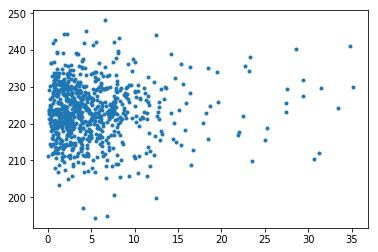

In [16]:
#V(r) 

pylab.plot(dist2,Vmed, '.' )

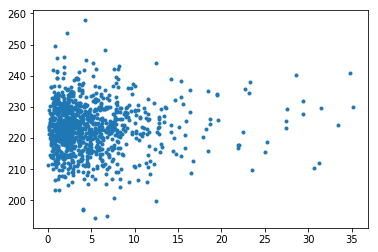

In [17]:
pylab.plot(dist,data['HV'], '.' )

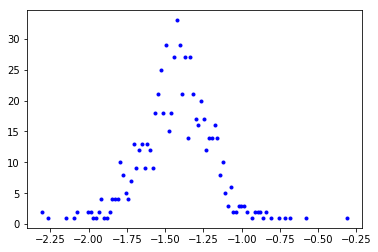

In [18]:
#distribution of Fe/H
Fe97 = []
for i in Fehcg97:
    Fe97.append(i)
count = []
value = []
n = 1
for i in range(len(Fe97)):
    if Fe97[i] != '+' and Fe97[i] != None:
        for j in range(i+1,len(Fe97)):
            if Fe97[i] == Fe97[j]:
                n += 1
                Fe97[j] ='+'
        count.append(n)
        value.append(Fe97[i])
        n=1
        
pylab.plot(value,count, '.b' )